In [1]:
import os
import random
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_data_dir = "/kaggle/input/dataset-bau/dataset_mymensingh"
working_dir = "/kaggle/working/rice_data"
batch_size = 32
num_classes = 6


In [3]:
def split_dataset(base_dir, output_dir, train_ratio=0.8):
    if os.path.exists(output_dir):
        print("Already split.")
        return

    os.makedirs(output_dir, exist_ok=True)
    train_dir = os.path.join(output_dir, "train")
    val_dir = os.path.join(output_dir, "val")
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    for class_name in os.listdir(base_dir):
        full_class_path = os.path.join(base_dir, class_name)
        if not os.path.isdir(full_class_path):
            continue
        images = os.listdir(full_class_path)
        random.shuffle(images)
        train_len = int(len(images) * train_ratio)

        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

        for img in images[:train_len]:
            shutil.copy(os.path.join(full_class_path, img), os.path.join(train_dir, class_name, img))
        for img in images[train_len:]:
            shutil.copy(os.path.join(full_class_path, img), os.path.join(val_dir, class_name, img))

split_dataset(base_data_dir, working_dir)


In [4]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(os.path.join(working_dir, 'train'), transform=train_transforms)
val_dataset = datasets.ImageFolder(os.path.join(working_dir, 'val'), transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

class_names = train_dataset.classes
print(f"Classes: {class_names}")


Classes: ['Bacterial_leaf_blight', 'Brown_Spot_Grain', 'Brown_Spot_Leaf', 'Rice_Blast', 'Sheath_blight', 'Sheath_rot']


In [5]:
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=5):
    history = {'train_loss': [], 'val_acc': []}
    model.to(device)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        val_acc = evaluate_model(model, val_loader)
        history['train_loss'].append(running_loss / len(train_loader))
        history['val_acc'].append(val_acc)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss:.4f}, Val Acc: {val_acc:.2f}%")

    return history

def evaluate_model(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total


In [6]:
def plot_history(history, title='Performance'):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss'); plt.grid(True)

    plt.subplot(1,2,2)
    plt.plot(history['val_acc'], label='Val Acc', color='orange')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy'); plt.grid(True)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


In [7]:
def plot_confusion_matrix(model, loader, class_names):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion Matrix")
    plt.show()
    print(classification_report(all_labels, all_preds, target_names=class_names))


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 207MB/s]
100%|██████████| 21/21 [01:25<00:00,  4.08s/it]


Epoch 1/20, Loss: 28.5347, Val Acc: 64.67%


100%|██████████| 21/21 [01:31<00:00,  4.37s/it]


Epoch 2/20, Loss: 14.5830, Val Acc: 86.83%


100%|██████████| 21/21 [01:26<00:00,  4.12s/it]


Epoch 3/20, Loss: 10.1538, Val Acc: 89.82%


100%|██████████| 21/21 [01:32<00:00,  4.40s/it]


Epoch 4/20, Loss: 8.7100, Val Acc: 85.03%


100%|██████████| 21/21 [01:32<00:00,  4.40s/it]


Epoch 5/20, Loss: 7.8474, Val Acc: 89.82%


100%|██████████| 21/21 [01:32<00:00,  4.39s/it]


Epoch 6/20, Loss: 6.4722, Val Acc: 94.01%


100%|██████████| 21/21 [01:31<00:00,  4.34s/it]


Epoch 7/20, Loss: 5.8790, Val Acc: 95.81%


100%|██████████| 21/21 [01:31<00:00,  4.37s/it]


Epoch 8/20, Loss: 5.1892, Val Acc: 95.81%


100%|██████████| 21/21 [01:31<00:00,  4.36s/it]


Epoch 9/20, Loss: 5.1817, Val Acc: 97.01%


100%|██████████| 21/21 [01:30<00:00,  4.32s/it]


Epoch 10/20, Loss: 5.4243, Val Acc: 95.81%


100%|██████████| 21/21 [01:32<00:00,  4.39s/it]


Epoch 11/20, Loss: 4.5674, Val Acc: 95.81%


100%|██████████| 21/21 [01:32<00:00,  4.42s/it]


Epoch 12/20, Loss: 4.5278, Val Acc: 97.60%


100%|██████████| 21/21 [01:31<00:00,  4.36s/it]


Epoch 13/20, Loss: 4.2551, Val Acc: 92.22%


100%|██████████| 21/21 [01:31<00:00,  4.36s/it]


Epoch 14/20, Loss: 3.8104, Val Acc: 95.81%


100%|██████████| 21/21 [01:31<00:00,  4.37s/it]


Epoch 15/20, Loss: 4.3283, Val Acc: 97.01%


100%|██████████| 21/21 [01:31<00:00,  4.38s/it]


Epoch 16/20, Loss: 3.7169, Val Acc: 92.81%


100%|██████████| 21/21 [01:32<00:00,  4.38s/it]


Epoch 17/20, Loss: 3.5891, Val Acc: 95.81%


100%|██████████| 21/21 [01:32<00:00,  4.38s/it]


Epoch 18/20, Loss: 2.9505, Val Acc: 98.80%


100%|██████████| 21/21 [01:33<00:00,  4.45s/it]


Epoch 19/20, Loss: 3.2677, Val Acc: 98.20%


100%|██████████| 21/21 [01:33<00:00,  4.45s/it]


Epoch 20/20, Loss: 3.7926, Val Acc: 98.20%


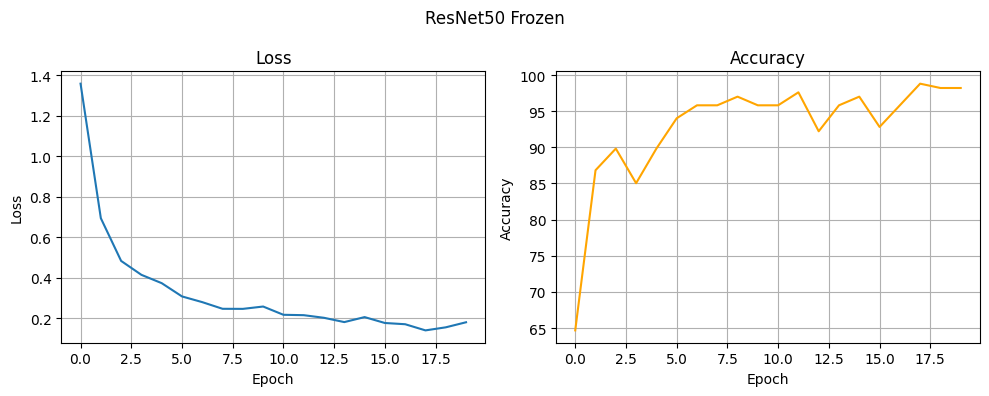

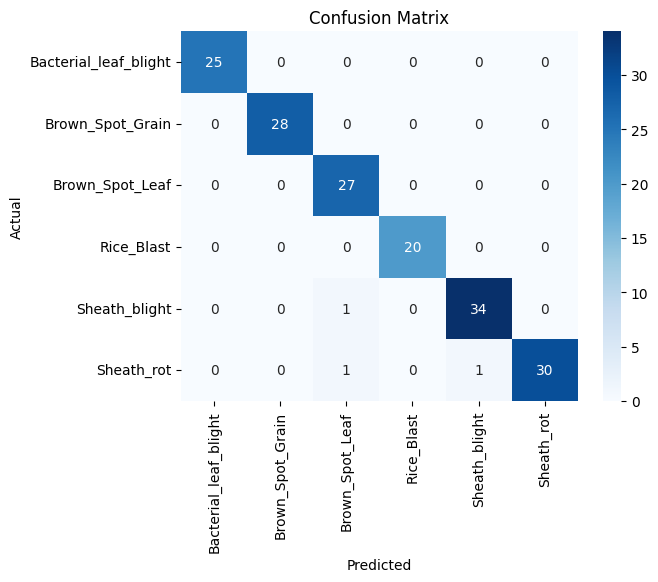

                       precision    recall  f1-score   support

Bacterial_leaf_blight       1.00      1.00      1.00        25
     Brown_Spot_Grain       1.00      1.00      1.00        28
      Brown_Spot_Leaf       0.93      1.00      0.96        27
           Rice_Blast       1.00      1.00      1.00        20
        Sheath_blight       0.97      0.97      0.97        35
           Sheath_rot       1.00      0.94      0.97        32

             accuracy                           0.98       167
            macro avg       0.98      0.98      0.98       167
         weighted avg       0.98      0.98      0.98       167



In [8]:
resnet = models.resnet50(pretrained=True)
for param in resnet.parameters(): param.requires_grad = False
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.fc.parameters(), lr=0.001)
resnet_history = train_model(resnet, criterion, optimizer, train_loader, val_loader, epochs=20)
plot_history(resnet_history, 'ResNet50 Frozen')
plot_confusion_matrix(resnet, val_loader, class_names)
torch.save(resnet.state_dict(), "resnet_frozen.pth")


100%|██████████| 21/21 [01:37<00:00,  4.65s/it]


Epoch 1/20, Loss: 2.8415, Val Acc: 100.00%


100%|██████████| 21/21 [01:36<00:00,  4.62s/it]


Epoch 2/20, Loss: 2.0353, Val Acc: 100.00%


100%|██████████| 21/21 [01:36<00:00,  4.62s/it]


Epoch 3/20, Loss: 1.5009, Val Acc: 100.00%


100%|██████████| 21/21 [01:36<00:00,  4.61s/it]


Epoch 4/20, Loss: 1.4652, Val Acc: 100.00%


100%|██████████| 21/21 [01:37<00:00,  4.63s/it]


Epoch 5/20, Loss: 1.7064, Val Acc: 100.00%


100%|██████████| 21/21 [01:37<00:00,  4.64s/it]


Epoch 6/20, Loss: 0.9094, Val Acc: 100.00%


100%|██████████| 21/21 [01:37<00:00,  4.63s/it]


Epoch 7/20, Loss: 1.1112, Val Acc: 100.00%


100%|██████████| 21/21 [01:37<00:00,  4.66s/it]


Epoch 8/20, Loss: 0.9533, Val Acc: 100.00%


100%|██████████| 21/21 [01:37<00:00,  4.65s/it]


Epoch 9/20, Loss: 1.2298, Val Acc: 100.00%


100%|██████████| 21/21 [01:37<00:00,  4.65s/it]


Epoch 10/20, Loss: 0.6826, Val Acc: 100.00%


100%|██████████| 21/21 [01:37<00:00,  4.66s/it]


Epoch 11/20, Loss: 0.7222, Val Acc: 100.00%


100%|██████████| 21/21 [01:36<00:00,  4.61s/it]


Epoch 12/20, Loss: 0.8445, Val Acc: 100.00%


100%|██████████| 21/21 [01:36<00:00,  4.59s/it]


Epoch 13/20, Loss: 0.7825, Val Acc: 100.00%


100%|██████████| 21/21 [01:36<00:00,  4.60s/it]


Epoch 14/20, Loss: 0.6237, Val Acc: 100.00%


100%|██████████| 21/21 [01:38<00:00,  4.67s/it]


Epoch 15/20, Loss: 0.8228, Val Acc: 100.00%


100%|██████████| 21/21 [01:37<00:00,  4.67s/it]


Epoch 16/20, Loss: 0.6950, Val Acc: 100.00%


100%|██████████| 21/21 [01:37<00:00,  4.66s/it]


Epoch 17/20, Loss: 0.7429, Val Acc: 100.00%


100%|██████████| 21/21 [01:37<00:00,  4.65s/it]


Epoch 18/20, Loss: 0.4550, Val Acc: 100.00%


100%|██████████| 21/21 [01:36<00:00,  4.61s/it]


Epoch 19/20, Loss: 0.8448, Val Acc: 100.00%


100%|██████████| 21/21 [01:37<00:00,  4.66s/it]


Epoch 20/20, Loss: 0.6605, Val Acc: 100.00%


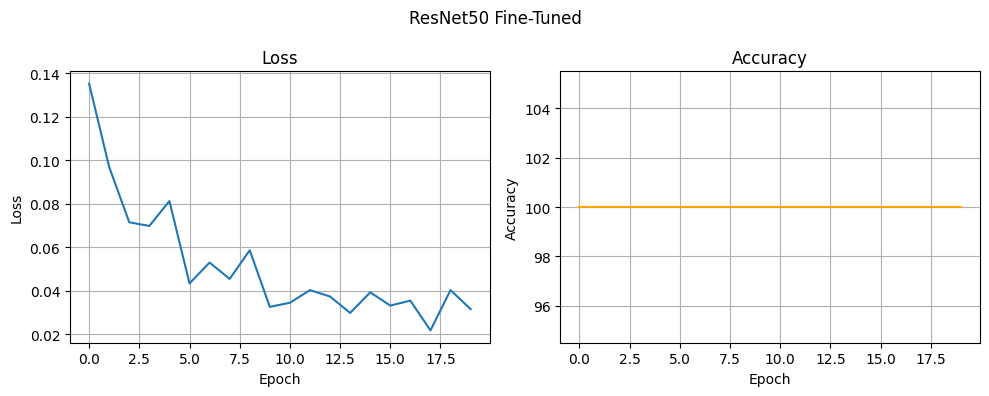

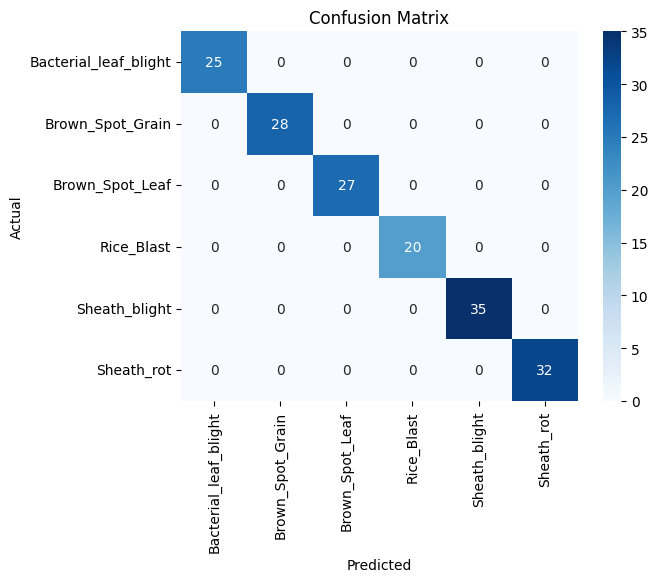

                       precision    recall  f1-score   support

Bacterial_leaf_blight       1.00      1.00      1.00        25
     Brown_Spot_Grain       1.00      1.00      1.00        28
      Brown_Spot_Leaf       1.00      1.00      1.00        27
           Rice_Blast       1.00      1.00      1.00        20
        Sheath_blight       1.00      1.00      1.00        35
           Sheath_rot       1.00      1.00      1.00        32

             accuracy                           1.00       167
            macro avg       1.00      1.00      1.00       167
         weighted avg       1.00      1.00      1.00       167



In [9]:
for param in resnet.parameters(): param.requires_grad = True
optimizer = optim.Adam(resnet.parameters(), lr=1e-5)
resnet_ft_history = train_model(resnet, criterion, optimizer, train_loader, val_loader, epochs=20)
plot_history(resnet_ft_history, 'ResNet50 Fine-Tuned')
plot_confusion_matrix(resnet, val_loader, class_names)
torch.save(resnet.state_dict(), "resnet_finetuned.pth")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 140MB/s] 
100%|██████████| 21/21 [01:29<00:00,  4.27s/it]


Epoch 1/20, Loss: 27.4129, Val Acc: 79.04%


100%|██████████| 21/21 [01:13<00:00,  3.51s/it]


Epoch 2/20, Loss: 15.4031, Val Acc: 92.81%


100%|██████████| 21/21 [01:29<00:00,  4.24s/it]


Epoch 3/20, Loss: 11.6546, Val Acc: 94.01%


100%|██████████| 21/21 [01:30<00:00,  4.29s/it]


Epoch 4/20, Loss: 9.0466, Val Acc: 95.81%


100%|██████████| 21/21 [01:31<00:00,  4.33s/it]


Epoch 5/20, Loss: 7.5544, Val Acc: 95.81%


100%|██████████| 21/21 [01:30<00:00,  4.30s/it]


Epoch 6/20, Loss: 7.2164, Val Acc: 95.21%


100%|██████████| 21/21 [01:31<00:00,  4.34s/it]


Epoch 7/20, Loss: 6.3855, Val Acc: 98.20%


100%|██████████| 21/21 [01:30<00:00,  4.33s/it]


Epoch 8/20, Loss: 6.0798, Val Acc: 97.60%


100%|██████████| 21/21 [01:31<00:00,  4.37s/it]


Epoch 9/20, Loss: 5.5835, Val Acc: 98.20%


100%|██████████| 21/21 [01:30<00:00,  4.32s/it]


Epoch 10/20, Loss: 5.5336, Val Acc: 97.01%


100%|██████████| 21/21 [01:31<00:00,  4.34s/it]


Epoch 11/20, Loss: 4.8791, Val Acc: 97.01%


100%|██████████| 21/21 [01:31<00:00,  4.36s/it]


Epoch 12/20, Loss: 5.4140, Val Acc: 98.20%


100%|██████████| 21/21 [01:31<00:00,  4.34s/it]


Epoch 13/20, Loss: 4.7654, Val Acc: 97.01%


100%|██████████| 21/21 [01:30<00:00,  4.32s/it]


Epoch 14/20, Loss: 4.3153, Val Acc: 98.80%


100%|██████████| 21/21 [01:31<00:00,  4.33s/it]


Epoch 15/20, Loss: 4.2993, Val Acc: 97.60%


100%|██████████| 21/21 [01:30<00:00,  4.30s/it]


Epoch 16/20, Loss: 5.2255, Val Acc: 98.20%


100%|██████████| 21/21 [01:30<00:00,  4.32s/it]


Epoch 17/20, Loss: 4.6004, Val Acc: 98.80%


100%|██████████| 21/21 [01:31<00:00,  4.37s/it]


Epoch 18/20, Loss: 4.1166, Val Acc: 98.80%


100%|██████████| 21/21 [01:31<00:00,  4.37s/it]


Epoch 19/20, Loss: 4.0845, Val Acc: 99.40%


100%|██████████| 21/21 [01:30<00:00,  4.33s/it]


Epoch 20/20, Loss: 4.0934, Val Acc: 98.20%


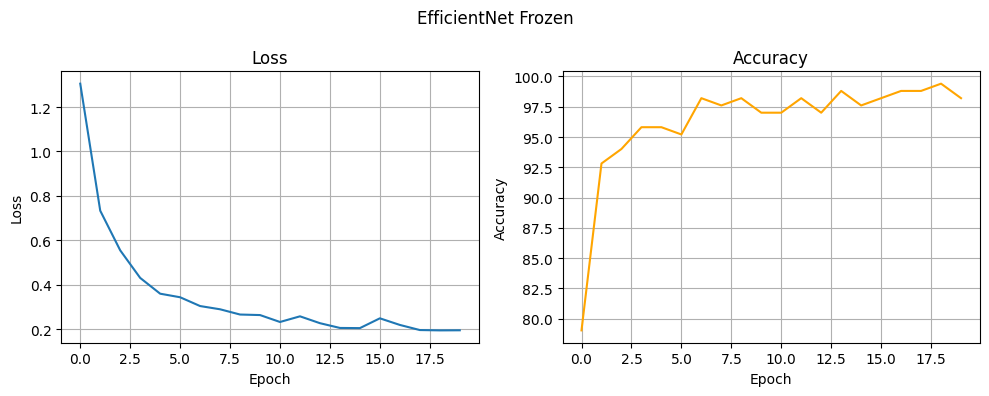

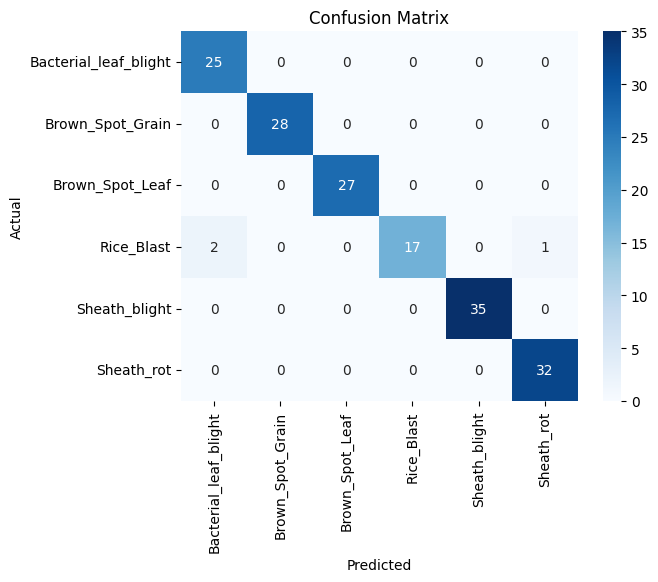

                       precision    recall  f1-score   support

Bacterial_leaf_blight       0.93      1.00      0.96        25
     Brown_Spot_Grain       1.00      1.00      1.00        28
      Brown_Spot_Leaf       1.00      1.00      1.00        27
           Rice_Blast       1.00      0.85      0.92        20
        Sheath_blight       1.00      1.00      1.00        35
           Sheath_rot       0.97      1.00      0.98        32

             accuracy                           0.98       167
            macro avg       0.98      0.97      0.98       167
         weighted avg       0.98      0.98      0.98       167



In [10]:
effnet = models.efficientnet_b0(pretrained=True)
for param in effnet.parameters(): param.requires_grad = False
effnet.classifier[1] = nn.Linear(effnet.classifier[1].in_features, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(effnet.classifier[1].parameters(), lr=0.001)
effnet_history = train_model(effnet, criterion, optimizer, train_loader, val_loader, epochs=20)
plot_history(effnet_history, 'EfficientNet Frozen')
plot_confusion_matrix(effnet, val_loader, class_names)
torch.save(effnet.state_dict(), "effnet_frozen.pth")


100%|██████████| 21/21 [01:33<00:00,  4.46s/it]


Epoch 1/20, Loss: 3.6282, Val Acc: 98.20%


100%|██████████| 21/21 [01:34<00:00,  4.50s/it]


Epoch 2/20, Loss: 3.7529, Val Acc: 98.20%


100%|██████████| 21/21 [01:34<00:00,  4.49s/it]


Epoch 3/20, Loss: 3.6079, Val Acc: 98.20%


100%|██████████| 21/21 [01:33<00:00,  4.45s/it]


Epoch 4/20, Loss: 3.2173, Val Acc: 98.20%


100%|██████████| 21/21 [01:32<00:00,  4.41s/it]


Epoch 5/20, Loss: 2.9106, Val Acc: 98.20%


100%|██████████| 21/21 [01:32<00:00,  4.42s/it]


Epoch 6/20, Loss: 2.5935, Val Acc: 98.80%


100%|██████████| 21/21 [01:32<00:00,  4.42s/it]


Epoch 7/20, Loss: 3.1484, Val Acc: 99.40%


100%|██████████| 21/21 [01:33<00:00,  4.43s/it]


Epoch 8/20, Loss: 3.0264, Val Acc: 99.40%


100%|██████████| 21/21 [01:33<00:00,  4.44s/it]


Epoch 9/20, Loss: 2.7030, Val Acc: 98.80%


100%|██████████| 21/21 [01:31<00:00,  4.36s/it]


Epoch 10/20, Loss: 2.7282, Val Acc: 99.40%


100%|██████████| 21/21 [01:33<00:00,  4.44s/it]


Epoch 11/20, Loss: 2.0808, Val Acc: 99.40%


100%|██████████| 21/21 [01:34<00:00,  4.49s/it]


Epoch 12/20, Loss: 2.2740, Val Acc: 98.80%


100%|██████████| 21/21 [01:33<00:00,  4.46s/it]


Epoch 13/20, Loss: 2.5256, Val Acc: 98.80%


100%|██████████| 21/21 [01:34<00:00,  4.48s/it]


Epoch 14/20, Loss: 1.8203, Val Acc: 98.80%


100%|██████████| 21/21 [01:34<00:00,  4.50s/it]


Epoch 15/20, Loss: 2.0189, Val Acc: 99.40%


100%|██████████| 21/21 [01:34<00:00,  4.48s/it]


Epoch 16/20, Loss: 1.9239, Val Acc: 99.40%


100%|██████████| 21/21 [01:33<00:00,  4.43s/it]


Epoch 17/20, Loss: 2.1994, Val Acc: 99.40%


100%|██████████| 21/21 [01:33<00:00,  4.45s/it]


Epoch 18/20, Loss: 1.9625, Val Acc: 98.80%


100%|██████████| 21/21 [01:33<00:00,  4.45s/it]


Epoch 19/20, Loss: 2.0422, Val Acc: 99.40%


100%|██████████| 21/21 [01:30<00:00,  4.30s/it]


Epoch 20/20, Loss: 1.8539, Val Acc: 99.40%


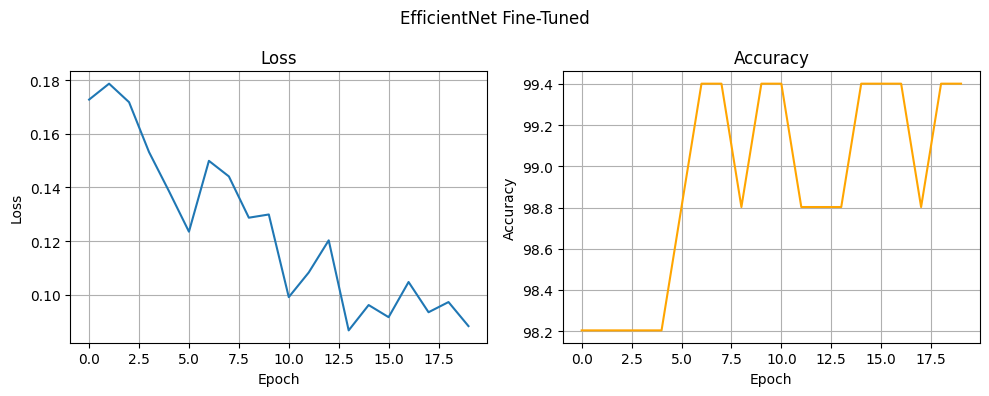

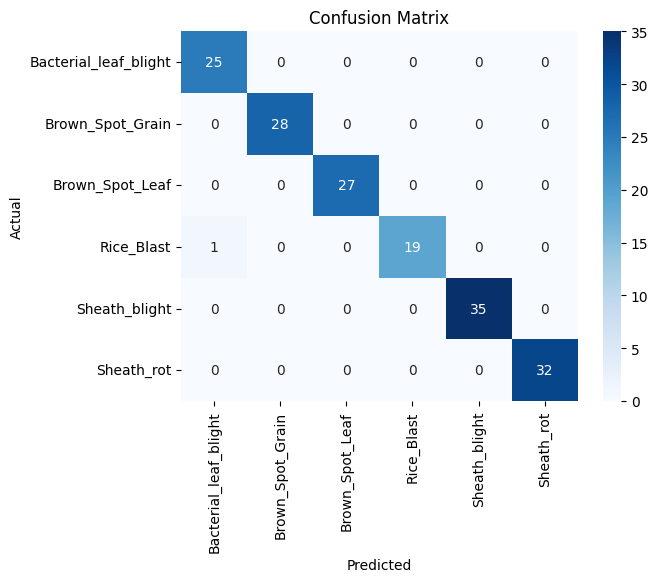

                       precision    recall  f1-score   support

Bacterial_leaf_blight       0.96      1.00      0.98        25
     Brown_Spot_Grain       1.00      1.00      1.00        28
      Brown_Spot_Leaf       1.00      1.00      1.00        27
           Rice_Blast       1.00      0.95      0.97        20
        Sheath_blight       1.00      1.00      1.00        35
           Sheath_rot       1.00      1.00      1.00        32

             accuracy                           0.99       167
            macro avg       0.99      0.99      0.99       167
         weighted avg       0.99      0.99      0.99       167



In [11]:
for param in effnet.parameters(): param.requires_grad = True
optimizer = optim.Adam(effnet.parameters(), lr=1e-5)
effnet_ft_history = train_model(effnet, criterion, optimizer, train_loader, val_loader, epochs=20)
plot_history(effnet_ft_history, 'EfficientNet Fine-Tuned')
plot_confusion_matrix(effnet, val_loader, class_names)
torch.save(effnet.state_dict(), "effnet_finetuned.pth")


100%|██████████| 21/21 [01:32<00:00,  4.38s/it]


Epoch 1/20, Loss: 34.9297, Val Acc: 56.29%


100%|██████████| 21/21 [01:26<00:00,  4.11s/it]


Epoch 2/20, Loss: 20.8940, Val Acc: 72.46%


100%|██████████| 21/21 [01:25<00:00,  4.09s/it]


Epoch 3/20, Loss: 14.9837, Val Acc: 85.63%


100%|██████████| 21/21 [01:15<00:00,  3.60s/it]


Epoch 4/20, Loss: 11.1891, Val Acc: 86.83%


100%|██████████| 21/21 [01:16<00:00,  3.65s/it]


Epoch 5/20, Loss: 11.1223, Val Acc: 82.04%


100%|██████████| 21/21 [01:29<00:00,  4.27s/it]


Epoch 6/20, Loss: 10.9049, Val Acc: 83.23%


100%|██████████| 21/21 [01:30<00:00,  4.32s/it]


Epoch 7/20, Loss: 9.0709, Val Acc: 92.22%


100%|██████████| 21/21 [01:16<00:00,  3.62s/it]


Epoch 8/20, Loss: 8.3817, Val Acc: 86.23%


100%|██████████| 21/21 [01:30<00:00,  4.29s/it]


Epoch 9/20, Loss: 7.9435, Val Acc: 89.22%


100%|██████████| 21/21 [01:30<00:00,  4.30s/it]


Epoch 10/20, Loss: 9.0872, Val Acc: 94.01%


100%|██████████| 21/21 [01:31<00:00,  4.34s/it]


Epoch 11/20, Loss: 8.2640, Val Acc: 95.21%


100%|██████████| 21/21 [01:28<00:00,  4.24s/it]


Epoch 12/20, Loss: 6.5325, Val Acc: 97.01%


100%|██████████| 21/21 [01:30<00:00,  4.30s/it]


Epoch 13/20, Loss: 7.4365, Val Acc: 93.41%


100%|██████████| 21/21 [01:29<00:00,  4.28s/it]


Epoch 14/20, Loss: 8.1665, Val Acc: 95.21%


100%|██████████| 21/21 [01:31<00:00,  4.34s/it]


Epoch 15/20, Loss: 7.7287, Val Acc: 98.20%


100%|██████████| 21/21 [01:30<00:00,  4.31s/it]


Epoch 16/20, Loss: 7.1359, Val Acc: 97.01%


100%|██████████| 21/21 [01:31<00:00,  4.35s/it]


Epoch 17/20, Loss: 7.3487, Val Acc: 97.01%


100%|██████████| 21/21 [01:32<00:00,  4.39s/it]


Epoch 18/20, Loss: 6.3261, Val Acc: 94.61%


100%|██████████| 21/21 [01:30<00:00,  4.32s/it]


Epoch 19/20, Loss: 6.6765, Val Acc: 96.41%


100%|██████████| 21/21 [01:31<00:00,  4.35s/it]


Epoch 20/20, Loss: 6.7589, Val Acc: 98.80%


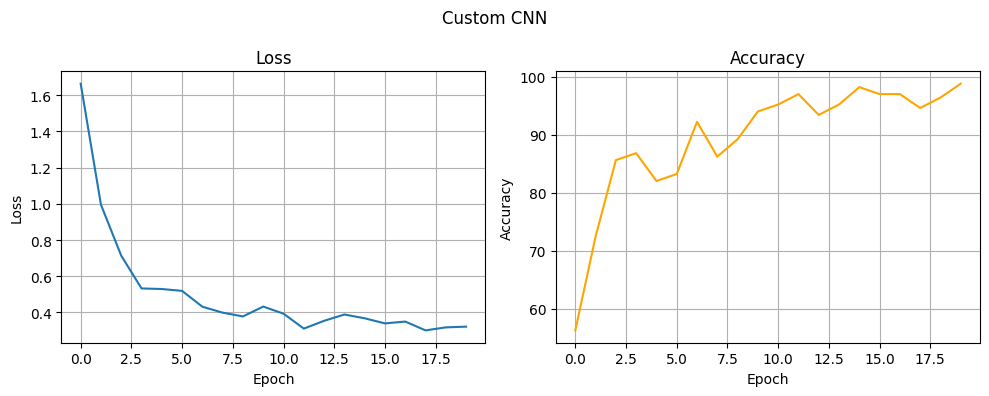

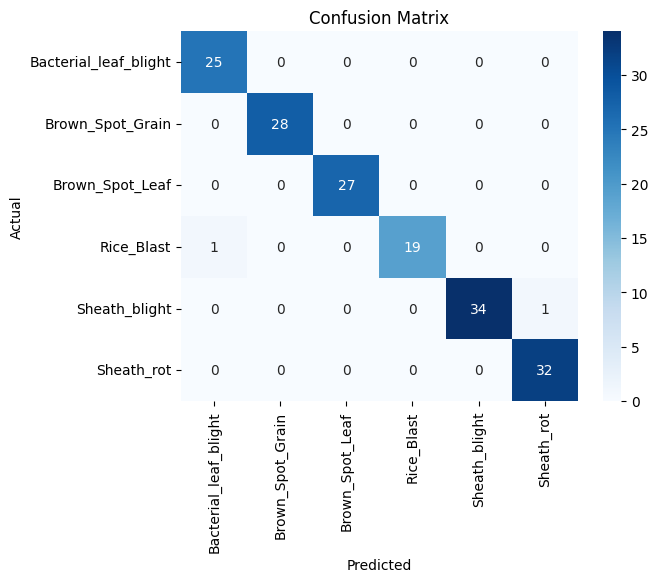

                       precision    recall  f1-score   support

Bacterial_leaf_blight       0.96      1.00      0.98        25
     Brown_Spot_Grain       1.00      1.00      1.00        28
      Brown_Spot_Leaf       1.00      1.00      1.00        27
           Rice_Blast       1.00      0.95      0.97        20
        Sheath_blight       1.00      0.97      0.99        35
           Sheath_rot       0.97      1.00      0.98        32

             accuracy                           0.99       167
            macro avg       0.99      0.99      0.99       167
         weighted avg       0.99      0.99      0.99       167



In [12]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*28*28, 256), nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

custom_model = CustomCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(custom_model.parameters(), lr=0.001)
custom_history = train_model(custom_model, criterion, optimizer, train_loader, val_loader, epochs=20)
plot_history(custom_history, 'Custom CNN')
plot_confusion_matrix(custom_model, val_loader, class_names)
torch.save(custom_model.state_dict(), "custom_cnn.pth")


In [13]:
def predict_image(model, image_path, transform, class_names):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        _, pred = torch.max(output, 1)

    plt.imshow(image)
    plt.title(f"Predicted: {class_names[pred.item()]}")
    plt.axis("off")
    plt.show()

# Example: Upload an image in Kaggle notebook
# predict_image(resnet, "/kaggle/input/some_test_image.jpg", val_transforms, class_names)


In [14]:
summary = {
    'Model': ['ResNet50 (Frozen)', 'ResNet50 (Fine-Tuned)', 'EfficientNetB0 (Frozen)', 'EfficientNetB0 (Fine-Tuned)', 'Custom CNN'],
    'Final Accuracy (%)': [
        resnet_history['val_acc'][-1],
        resnet_ft_history['val_acc'][-1],
        effnet_history['val_acc'][-1],
        effnet_ft_history['val_acc'][-1],
        custom_history['val_acc'][-1]
    ]
}

import pandas as pd
results_df = pd.DataFrame(summary)
results_df.sort_values('Final Accuracy (%)', ascending=False).reset_index(drop=True)


,Model,Final Accuracy (%)
0,ResNet50 (Fine-Tuned),100.000000
1,EfficientNetB0 (Fine-Tuned),99.401198
2,Custom CNN,98.802395
3,ResNet50 (Frozen),98.203593
4,EfficientNetB0 (Frozen),98.203593
